In [1]:
import numpy as np
import pandas as pd
import optuna
import pickle
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, plot_importance
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1/train_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1/test_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [3]:
train_df

,year,country,population_lag_1,gdp_lag_1,temperature_change_from_co2_lag_1,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,co2
0,1929,Argentina,0.006899,0.007941,0.026846,0.000247,0.001689,0.000000,0.000253,0.189716,0.001601,0.057195
1,1930,Argentina,0.007131,0.008313,0.026846,0.000370,0.001696,0.000000,0.000390,0.190037,0.001654,0.050794
2,1931,Argentina,0.007348,0.007961,0.026846,0.000402,0.001655,0.000000,0.000386,0.170616,0.001586,0.046617
3,1932,Argentina,0.007548,0.007396,0.026846,0.000564,0.001416,0.000000,0.000480,0.157812,0.002007,0.044323
4,1933,Argentina,0.007730,0.007146,0.026846,0.000525,0.001291,0.000000,0.000655,0.150694,0.002278,0.042756
...,...,...,...,...,...,...,...,...,...,...,...,...
3139,2003,Vietnam,0.059915,0.026230,0.026846,0.017601,0.005604,0.013673,0.003490,0.148809,0.011342,0.055115
3140,2004,Vietnam,0.060551,0.028076,0.026846,0.019924,0.006518,0.016147,0.004431,0.157641,0.011685,0.057655
3141,2005,Vietnam,0.061188,0.030178,0.026846,0.021913,0.007093,0.015907,0.007456,0.160666,0.013424,0.052390
3142,2006,Vietnam,0.061822,0.032375,0.026846,0.025491,0.008044,0.015322,0.007996,0.141767,0.013411,0.050074


In [4]:
# Load the fitted DataScaler object
with open('../output/0_data_cleaning/lightgbm/lag1/data_preprocessor_lightgbm1.pkl', 'rb') as f:
    data_preprocessor_lightgbm = pickle.load(f)

In [5]:
# Count rows for each country in train and test datasets
train_country_counts = train_df['country'].value_counts().reset_index()
train_country_counts.columns = ['country', 'train_count']

test_country_counts = test_df['country'].value_counts().reset_index()
test_country_counts.columns = ['country', 'test_count']

# Merge the counts into a single DataFrame
country_counts_df = pd.merge(
    train_country_counts,
    test_country_counts,
    on='country',
    how='outer'  # Keeps all countries, even if they are only in train or test
).fillna(0)  # Fill missing counts with 0 if a country is missing in one dataset

# Ensure counts are integers
country_counts_df['train_count'] = country_counts_df['train_count'].astype(int)
country_counts_df['test_count'] = country_counts_df['test_count'].astype(int)

# Display the result
country_counts_df.sort_values(by=['train_count'], ascending=False)

,country,train_count,test_count
41,United States,136,35
23,Netherlands,136,35
16,Indonesia,106,27
21,Malaysia,97,25
43,Venezuela,94,24
35,Sweden,91,23
33,South Korea,88,23
8,Colombia,80,21
27,Philippines,75,19
1,Australia,75,19


In [6]:
def log_mape(y_true, y_pred):
    return np.mean(np.abs((np.log1p(y_true) - np.log1p(y_pred)) / np.log1p(y_true)))

In [7]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    # param = {
    #     'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
    #     'num_leaves': trial.suggest_int('num_leaves', 15, 50),
    #     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30), #4/5-30
    #     'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 0.001, 10),
    #     'max_depth': trial.suggest_int('max_depth', 3, 12), # 1-5
    #     'num_threads': trial.suggest_int('num_threads', 2, 8),
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # 10-100
    #     #deal with overfitting
    #     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
    #     'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
    #     'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),

    #     'verbosity': -1,

    #     'objective':'regression_l1',
    #     'metric':'mae',
    #     'is_unbalance':True,
    # }
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 30), #4/5-30 moje: 1, 30
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 0.001, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 5), # 1-5 moje: 3, 12
        'num_threads': trial.suggest_int('num_threads', 1, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100), # 10-100 moje: 100, 1000
        #deal with overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 6.0, 10.0),

        'verbosity': -1,

        'objective':'regression_l1',
        # 'metric':'mae',
        # 'is_unbalance':True,
    }

    # Initialize the model
    model_optuna = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model_optuna = MLForecast(
        models=[model_optuna],
        freq=1,
        date_features=None,
        num_threads=2
    )

    # Perform cross-validation manually with dynamic horizons
    all_cv_predictions = []

    for country, country_data in train_df.groupby('country'):
        # Calculate the horizon dynamically
        horizon = max(1, int(0.15 * len(country_data)))

        # Perform cross-validation for this country
        cv_predictions = forecast_model_optuna.cross_validation(
            df=country_data,
            h=horizon,
            n_windows=2,
            step_size=horizon//2,
            id_col='country',
            time_col='year',
            target_col='co2',
            static_features=[]
        )

        # Add the country information to the predictions
        cv_predictions['country'] = country
        all_cv_predictions.append(cv_predictions)

    # Concatenate all predictions into a single DataFrame
    cv_predictions = pd.concat(all_cv_predictions).reset_index(drop=True)

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
    cv_predictions = cv_predictions.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    # mape = mean_absolute_percentage_error(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    # return mape
    # Calculate log-MAPE
    log_mape_value = log_mape(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    return log_mape_value 

In [8]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-21 22:03:01,460] A new study created in memory with name: no-name-43fa58df-23f8-4d85-b239-d485eb35256c
[I 2024-11-21 22:03:03,536] Trial 0 finished with value: 0.17010125249247124 and parameters: {'learning_rate': 0.06972249860515035, 'num_leaves': 37, 'min_data_in_leaf': 21, 'max_depth': 4, 'num_threads': 3, 'n_estimators': 73, 'bagging_fraction': 0.9766286113293785, 'feature_fraction': 0.967026784802678, 'lambda_l1': 1.3629389663828726, 'lambda_l2': 9.82255955140393}. Best is trial 0 with value: 0.17010125249247124.
[I 2024-11-21 22:03:05,819] Trial 1 finished with value: 0.14403083376699288 and parameters: {'learning_rate': 0.09397295658296945, 'num_leaves': 33, 'min_data_in_leaf': 9, 'max_depth': 3, 'num_threads': 5, 'n_estimators': 52, 'bagging_fraction': 0.8093466882056375, 'feature_fraction': 0.8897046268947358, 'lambda_l1': 6.102592986787794, 'lambda_l2': 6.451231914151123}. Best is trial 1 with value: 0.14403083376699288.
[I 2024-11-21 22:03:07,758] Trial 2 finished

Best Hyperparameters: {'learning_rate': 0.09397295658296945, 'num_leaves': 33, 'min_data_in_leaf': 9, 'max_depth': 3, 'num_threads': 5, 'n_estimators': 52, 'bagging_fraction': 0.8093466882056375, 'feature_fraction': 0.8897046268947358, 'lambda_l1': 6.102592986787794, 'lambda_l2': 6.451231914151123}


In [9]:
best_params

{'learning_rate': 0.09397295658296945,
 'num_leaves': 33,
 'min_data_in_leaf': 9,
 'max_depth': 3,
 'num_threads': 5,
 'n_estimators': 52,
 'bagging_fraction': 0.8093466882056375,
 'feature_fraction': 0.8897046268947358,
 'lambda_l1': 6.102592986787794,
 'lambda_l2': 6.451231914151123}

In [23]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    #**best_params,
    learning_rate= 0.08851782585381036, 
    num_leaves= 43, 
    min_data_in_leaf= 14,
    max_depth= 4, 
    num_threads= 3, 
    n_estimators= 99, 
    bagging_fraction= 0.9016913723278043, 
    feature_fraction= 0.814984768684116, 
    lambda_l1= 2.234259007831305, 
    lambda_l2= 8.594058231373058,
    verbosity=-1,

    objective= 'regression_l1',
    metric= 'mae',
    is_unbalance= False,
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    date_features=None,
    num_threads=2
)

train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

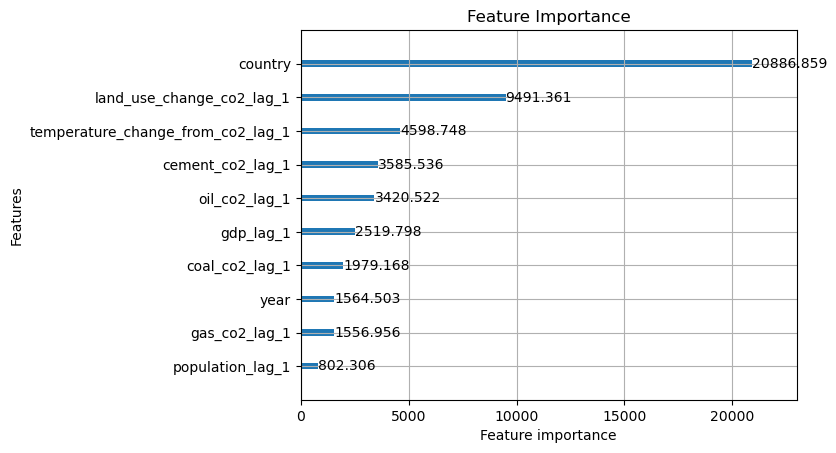

In [24]:
#Check feature importance
# Separate features and target
X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']

# Convert 'country' to a categorical feature
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [25]:
# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=[], date_features=[], num_threads=2)

In [26]:
#TRAIN DATA
fitted_values = forecast_model.forecast_fitted_values()
results_train = fitted_values.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

#predicted inverse transform
results_train_inverse = results_train.copy()

output_train_predicted = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_train_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_train_predicted, results_train.shape[0], train_df.shape[1]-2)
last_column_train_predicted = inverted_data_train_predicted[:, -1]
results_train_inverse['co2_predicted'] = last_column_train_predicted

output_train_actual = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_train_actual = data_preprocessor_lightgbm.inverse_transform_data(output_train_actual, results_train.shape[0], train_df.shape[1]-2)
last_column_train_actual = inverted_data_train_actual[:, -1]
results_train_inverse['co2_actual'] = last_column_train_actual

results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1929,242.878,220.414482
1,Argentina,1930,194.678,219.935897
2,Argentina,1931,163.215,211.540368
3,Argentina,1932,145.940,165.755383
4,Argentina,1933,134.144,139.131421
...,...,...,...,...
3139,Vietnam,2003,227.212,212.747828
3140,Vietnam,2004,246.341,241.835800
3141,Vietnam,2005,206.696,243.025751
3142,Vietnam,2006,189.254,151.463141


In [27]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
train_mape = mean_absolute_percentage_error(results_train_inverse['co2_actual'], results_train_inverse['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 0.21201366891367848


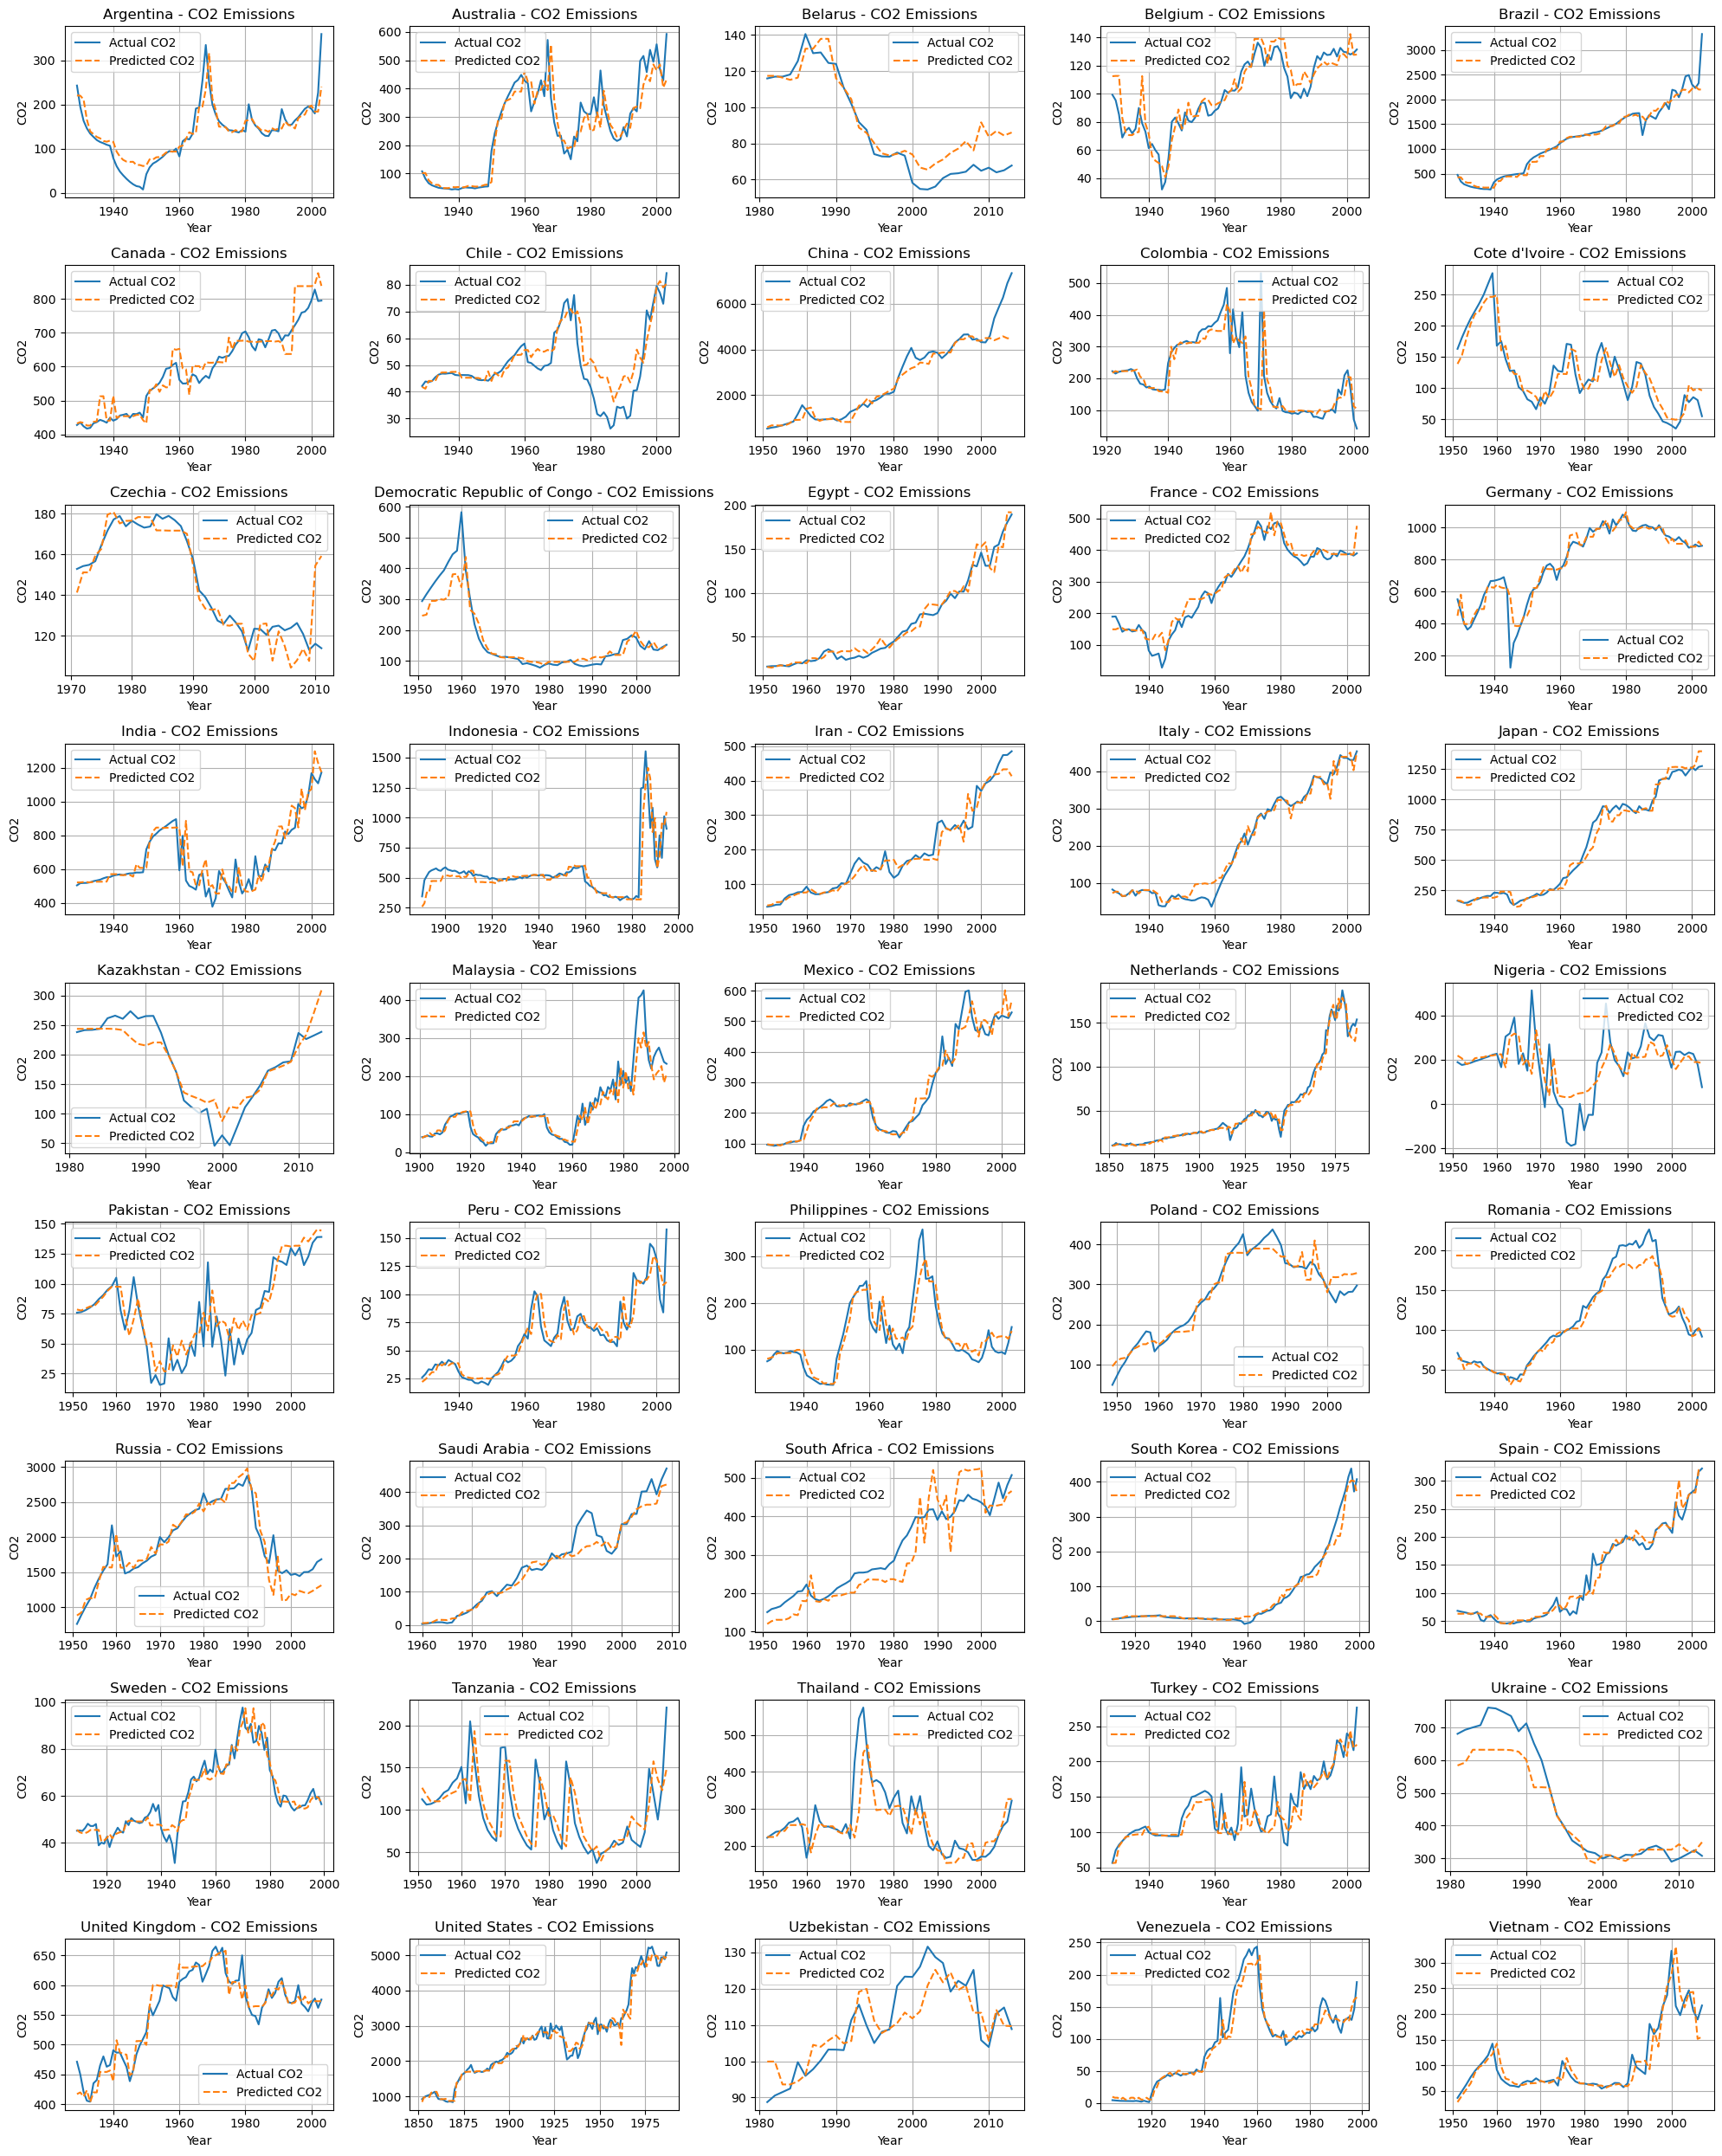

In [28]:
#TRAIN DATA

num_rows = 9
num_cols = 5
countries = results_train_inverse['country'].unique()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train_inverse[results_train_inverse['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [29]:
all_predictions = []

for country in test_df['country'].unique():

    country_test_data = test_df[test_df['country'] == country].copy()
    horizon = country_test_data['year'].nunique()

    country_test_features = country_test_data.loc[:, country_test_data.columns != 'co2']

    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids=[country])

    country_predictions['country'] = country
    country_predictions['year'] = country_test_data['year'].values[:len(country_predictions)]
    country_predictions = country_predictions.merge(
        country_test_data[['year', 'co2']],
        on='year',
        how='left'
    ).rename(columns={'co2': 'co2_actual'})

    all_predictions.append(country_predictions)

results_test = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2_predicted'})

#predicted inverse transform
results_test_inverse = results_test.copy()

output_test_predicted = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_test_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_test_predicted, results_test.shape[0], test_df.shape[1]-2)
last_column_test_predicted = inverted_data_test_predicted[:, -1]
results_test_inverse['co2_predicted'] = last_column_test_predicted

output_test_actual = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_test_actual = data_preprocessor_lightgbm.inverse_transform_data(output_test_actual, results_test.shape[0], test_df.shape[1]-2)
last_column_test_actual = inverted_data_test_actual[:, -1]
results_test_inverse['co2_actual'] = last_column_test_actual

results_test_inverse

,country,year,co2_predicted,co2_actual
0,Argentina,2004,297.286330,450.881
1,Argentina,2005,339.602538,487.442
2,Argentina,2006,354.612649,505.851
3,Argentina,2007,354.612649,353.365
4,Argentina,2008,259.058858,293.438
...,...,...,...,...
805,Vietnam,2018,454.787336,504.751
806,Vietnam,2019,455.177026,589.843
807,Vietnam,2020,453.713715,613.079
808,Vietnam,2021,453.713715,605.475


In [30]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_test = mean_absolute_percentage_error(results_test_inverse['co2_actual'], results_test_inverse['co2_predicted'])
print(f"Test MAPE: {mape_test}")

Test MAPE: 0.41777494319029024


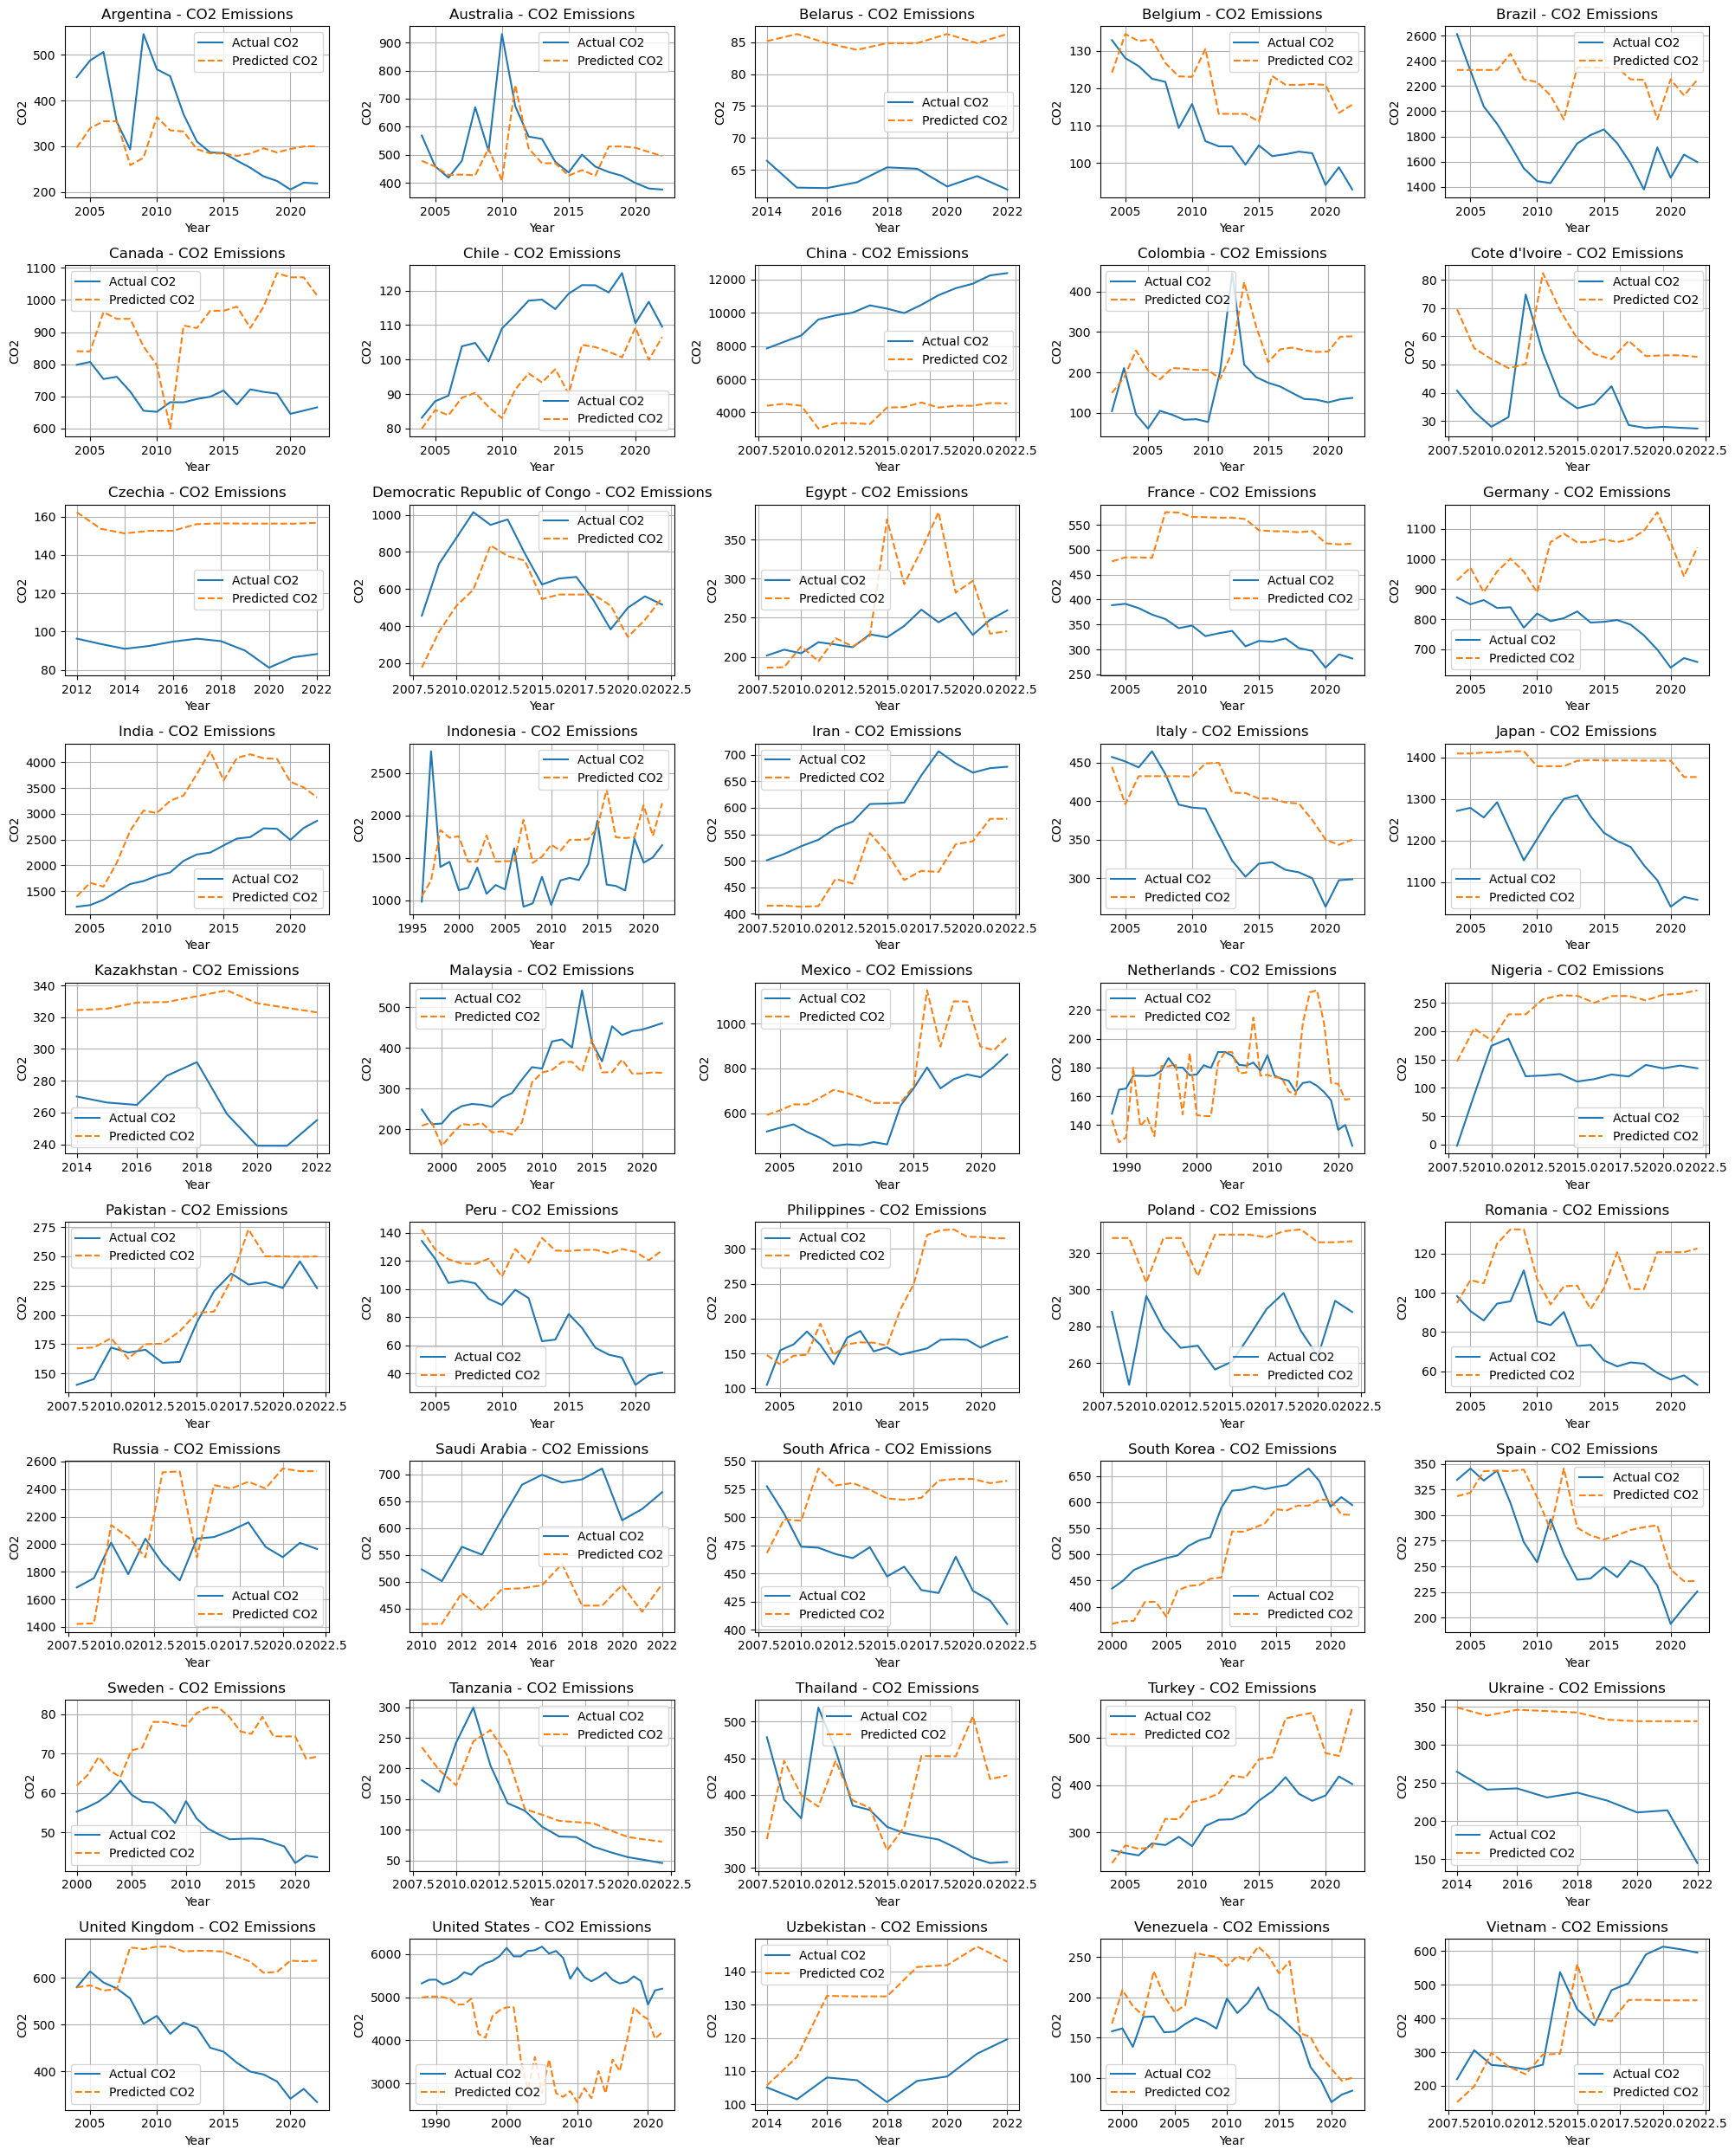

In [31]:
#TEST DATA
num_rows = 9
num_cols = 5
countries = results_test_inverse['country'].unique() 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    country_results = results_test_inverse[results_test_inverse['country'] == country]
    ax = axes[i]
    
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [32]:
# Custom R2 function
def custom_r2_score(y_actual, y_predicted):

    ss_total = np.sum((y_actual - np.mean(y_actual)) ** 2)
    ss_residual = np.sum((y_actual - y_predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return max(0, r2)

In [33]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_train_inverse['country'].unique():
    country_df = results_train_inverse[results_train_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_train_inverse['co2_actual']
overall_predicted = results_train_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE         MAE        RMSE        R2
0                      Argentina  0.375825   19.048306   29.887342  0.798474
1                      Australia  0.137838   38.749438   61.714694  0.853252
2                        Belarus  0.124766    8.765105   11.303943  0.831433
3                        Belgium  0.087562    7.773637    9.941135  0.844134
4                         Brazil  0.078087   73.880038  159.045615  0.947001
5                         Canada  0.049464   30.071144   41.037458  0.870467
6                          Chile  0.119021    4.886651    6.849277  0.717967
7                          China  0.103867  313.881667  631.849808  0.876029
8                       Colombia  0.152848   30.456322   64.839039  0.672863
9                  Cote d'Ivoire  0.183783   19.270248   24.076777  0.824603
10                       Czechia  0.056172    7.396445   11.729379  0.764018
11  Democratic Republic of Congo  0.123380   26.574474  

In [34]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_test_inverse['country'].unique():
    country_df = results_test_inverse[results_test_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_test_inverse['co2_actual']
overall_predicted = results_test_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE          MAE         RMSE        R2
0                      Argentina  0.214045    76.393383   102.168963  0.125362
1                      Australia  0.168836    94.728081   149.766407  0.000000
2                        Belarus  0.340155    21.588336    21.685546  0.000000
3                        Belgium  0.131379    13.691587    15.236765  0.000000
4                         Brazil  0.329788   535.434111   579.007622  0.000000
5                         Canada  0.336718   232.341195   256.478577  0.000000
6                          Chile  0.135052    15.313628    17.422494  0.000000
7                          China  0.592155  6151.945028  6293.946466  0.000000
8                       Colombia  0.949144   114.887671   124.710785  0.000000
9                  Cote d'Ivoire  0.706774    23.964107    24.543704  0.000000
10                       Czechia  0.705785    64.113112    64.320820  0.000000
11  Democratic Republic of Congo

In [35]:
results_by_country_df[results_by_country_df['R2'] > 0].reset_index(drop = True)

,country,MAPE,MAE,RMSE,R2
0,Argentina,0.214045,76.393383,102.168963,0.125362
1,Malaysia,0.191654,68.468121,81.229815,0.224676
2,Pakistan,0.099146,18.437396,22.113062,0.598530
3,Spain,0.143881,35.939792,42.279615,0.124080
4,Tanzania,0.379051,39.771738,44.072349,0.642333
5,Vietnam,0.203705,92.159577,113.504612,0.389376
